In [80]:
# import all pacckages required
import random
import copy
import matplotlib.pyplot as plt
import numpy as np

# for formatting output
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Function to generate a single task with random values
def init_task(dataRate,dataSize,workload):
  task = {
      "dataRate": dataRate,
      "dataSize": dataSize,
      "workload": workload,
  }
  return task

# Function to generate multiple tasks by calling init_task()
def generateTasks(numTasks,dataRate,dataSize,workload):
  tasks=[]
  for i in range(numTasks):
    if(dataRate == 0):
      dr = random.randrange(50,100,10)
    else: 
      dr= dataRate
    
    if(dataSize == 0):
      ds = (random.randrange(5,45,5)/10)
    else:
      ds = dataSize
    
    if(workload == 0):
      wl = random.randrange(30,55,5)
    else: 
      wl = workload

    task=init_task(dr,ds,wl)
    tasks.append(task)
  return tasks 

# Function to create a server with given values
def init_server(buffer,freq,t_frac,arrivalRate,serviceRate):
  server={
      'buffer': buffer,
      'frequency': freq,
      'timeFraction' : t_frac,
      'arrivalRate': arrivalRate,
      'serviceRate': serviceRate,
      'prev_delay': 0
  }
  return server

# Function to geenrate multiple servers with given/random values
def generateServers(numServers,buffer,freq,arrRate,svcRate):
  servers = []
  for i in range(numServers):

    if(buffer == 0):
      taskBufferCapacity = random.randrange(4,11,1)
    else: 
      taskBufferCapacity = buffer

    if(freq == 0):
      frequency = random.randrange(1500,3300,300)
    else:
      frequency = freq

    if(arrRate == 0):
      arrivalRate = random.randrange(20,50,5)
    else:
      arrivalRate = arrRate

    if(svcRate == 0):
      serviceRate = random.randrange(250,310,10);
    else: 
      serviceRate = svcRate

    if(numServers == 4):
      time_fraction = 0.5
    elif(numServers == 5):
      time_fraction = 0.625    
    elif(numServers == 6):
      time_fraction = 0.75
    elif(numServers == 7):
      time_fraction = 0.875
    else:
      time_fraction = 0.9
    server = init_server(taskBufferCapacity,frequency,time_fraction,arrivalRate,serviceRate)
    servers.append(server)
  return servers

In [208]:
def greedyAlgo(run_tasks,generatedServersOriginal,generatedTasksOriginal,server_num,wup = 30):

  #make a copy of generated tasks and severs
  generatedServers = []
  generatedTasks = []

  #Duplicate Servers
  for li in generatedServersOriginal:
    d2 = copy.deepcopy(li)
    generatedServers.append(d2)
  
  #Duplicate tasks
  for li in generatedTasksOriginal:
    d2 = copy.deepcopy(li)
    generatedTasks.append(d2)

  # iterating through tasks
  server_alloc = []
  greedy_delay = []
  total_time = 0
  exec_time = []
  for i in range(run_tasks):
    #iterate through servers
    best_time = 1000
    best_server = -1
    best_delay = 0
    for j in range(server_num):
      if(generatedServers[j]['buffer']>=1):
        task_arrival = generatedServers[j]['arrivalRate'] * generatedServers[j]['timeFraction']                         # Aij
        # transmission_delay = task_arrival * (generatedTasks[i]['dataSize'] / generatedTasks[i]['dataRate'])           # Sum of transmission delay of all tasks
        transmission_delay = (generatedTasks[i]['dataSize']/generatedTasks[i]['dataRate'])                              # Lij transmission delay of each task
        computation_time = (generatedTasks[i]['workload'] / generatedServers[j]['frequency'])
        delay_sub = 0
        if(generatedServers[j]['prev_delay'] - transmission_delay > 0):
          delay_sub = generatedServers[j]['prev_delay'] - transmission_delay
        queuing_delay = (1000/ (generatedServers[j]['serviceRate'] - task_arrival))                                        # queuing delay for each task
        total_time = transmission_delay + queuing_delay + computation_time + delay_sub
        total_delay = transmission_delay + queuing_delay + delay_sub
        # print("Queue delay - ", queuing_delay, "Transmission delay - ",transmission_delay)
        #check if solution is better than previous
        if(best_time > total_time and transmission_delay + queuing_delay < wup):
          best_time = total_time
          best_server = j
          best_delay = total_delay
        else:
          # print('previous best time - {} for server - {}'.format(best_time, best_server))
          break
      # else: 
      #   print('Server :  {} cannot accomodate more tasks'.format(j))
    generatedServers[best_server]['buffer'] = generatedServers[best_server]['buffer'] - 1
    generatedServers[best_server]['prev_delay'] = generatedServers[best_server]['prev_delay'] + best_time
    # print('Task: {} ; alloted to server : {} , best time: {}'.format(i,best_server,best_time))
    server_alloc.append(best_server)
    greedy_delay.append(best_delay)
    exec_time.append(best_time)
  return server_alloc,greedy_delay,exec_time#,generatedServers



In [209]:
def swap_server(originalServer, number_servers,start=0):
  temp = list(range(start, originalServer)) + list(range(originalServer+1, number_servers-1))
  return random.choice(temp)

# Tabu search algorithm
def tabu_search(generatedServersOriginal,generatedTasksOriginal,greedy_policy_input, greedy_policy_time,tasks_to_run=30,wup =30 ):
  #make a copy of generated tasks and severs
  generatedServers = []
  generatedTasks = []

  #Duplicate Servers
  for li in generatedServersOriginal:
    d2 = copy.deepcopy(li)
    generatedServers.append(d2)
  
  #Duplicate tasks
  for li in generatedTasksOriginal:
    d2 = copy.deepcopy(li)
    generatedTasks.append(d2)

  tabu_policy = list(greedy_policy_input)
  greedy_time = list(greedy_policy_time)
  i=0
  while i< tasks_to_run: #Outer loop termination condition TBD
    total_time_tabu = []
    exec_time = 0
    temp = greedy_time[i]
    qtemp = tabu_policy[i]
    qbest = tabu_policy[i]
    h=0
    tabulist = []
    tabulist.append(tabu_policy[i])
    while h< 2:
      #Randomly swap allocated server to get qrand 
      qrand = swap_server(i,8)
      if(qrand not in tabulist and qrand <len(generatedServers) and generatedServers[qrand]['buffer'] >= 1):
        task_arrival = generatedServers[qrand]['arrivalRate'] * generatedServers[qrand]['timeFraction']                         # Aij  
        transmission_delay = (generatedTasksOriginal[i]['dataSize']/generatedTasksOriginal[i]['dataRate'])                              # Lij transmission delay of each task
        computation_time = (generatedTasksOriginal[i]['workload'] / generatedServers[qrand]['frequency'])
        delay_sub = 0
        if(generatedServers[qrand]['prev_delay'] - transmission_delay > 0):
          delay_sub = generatedServers[qrand]['prev_delay'] - transmission_delay
        # computation_time = computation_time * 10
        queuing_delay = (1000/ (generatedServers[qrand]['serviceRate'] - task_arrival))                                        # queuing delay for each task
        total_time = transmission_delay + queuing_delay + computation_time + delay_sub
        total_delay = transmission_delay + queuing_delay + delay_sub
        if(total_delay < temp and transmission_delay + queuing_delay < wup):
          # if(i < 2):
          #   print("Better solution found - ", temp, " old solution - ",total_delay, "new server - ",qrand, " old server - ",tabu_policy[i])
          h = 0
          exec_time = total_time
          temp = total_delay
          tabulist.append(qrand)
          qtemp = qrand
        else:
          h = h+1
    if(temp < greedy_time[i]):
      greedy_time[i] = temp
      tabu_policy[i] = qtemp
      total_time_tabu.append(exec_time)
      generatedServers[qtemp]['buffer'] = generatedServers[qtemp]['buffer'] - 1
      generatedServers[qtemp]['prev_delay'] = generatedServers[qtemp]['prev_delay'] + temp
    else:
      generatedServers[tabu_policy[i]]['buffer'] = generatedServers[tabu_policy[i]]['buffer'] - 1
      generatedServers[tabu_policy[i]]['prev_delay'] = generatedServers[tabu_policy[i]]['prev_delay'] + total_time
    i = i+1
  return tabu_policy, greedy_time,total_time_tabu


In [153]:
# create common tasks and servers for greedy and tabu search algo
common_servers = generateServers(8,0,0,0,0)
common_tasks = generateTasks(30,0,0,0)

greedy delay -  57.038396927801664
tabu s delay - >  43.84554869578675
Greedy algo is 23.129766863388916% better
greedy delay -  120.30563794487914
tabu s delay - >  83.08181543177336
Greedy algo is 30.941045780548325% better
greedy delay -  194.99037298514597
tabu s delay - >  120.74062167147436
Greedy algo is 38.07867546328958% better
greedy delay -  291.58763005453244
tabu s delay - >  206.55266954857422
Greedy algo is 29.162746200877955% better
greedy delay -  428.34405843712017
tabu s delay - >  382.9916890465215
Greedy algo is 10.58783669279173% better


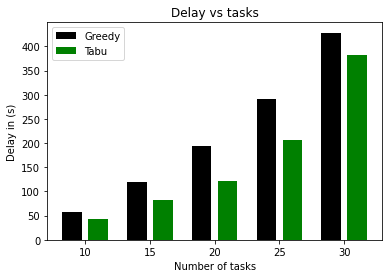

In [217]:
def difference(greed_policy, tabu_policy):
  print()
  print(greed_policy)
  for i in range(len(tabu_policy)):
    if(greed_policy[i] == tabu_policy[i]):
      print(bcolors.ENDC,greed_policy[i], end = ",")
    else:
      print(bcolors.FAIL,tabu_policy[i], end = ',')
  print(bcolors.ENDC)

def perc_diff(greedy_delay, tabu_delay):
  diff = 100 * ((sum(greedy_delay) - sum(tabu_delay))/sum(greedy_delay))
  print('Greedy algo is ' + bcolors.FAIL + '{}% better'.format(diff) + bcolors.ENDC)

def test():
  greedy_delays = []
  tabu_delays = []
  total_tasks = []
  for i in range(5):
    tasks = 10 + 5*i
    total_tasks.append(tasks)
    # get greedy policy 
    greed_policy, delay,total_time = greedyAlgo(tasks,common_servers,common_tasks,len(common_servers))
    greedy_delays.append(sum(delay))
    print("greedy delay - ",sum(delay))
    # print("greedy Total time - ",sum(total_time))

    tabu_policy,tabu_delay,tabu_total_time = tabu_search(common_servers,common_tasks,greed_policy,delay,tasks)
    tabu_delays.append(sum(tabu_delay))
    print('tabu s delay - > ',sum(tabu_delay))
    # print('tabu s total time - ',sum(tabu_total_time))

    # difference(greed_policy, tabu_policy)
    perc_diff(delay,tabu_delay)

  X_axis = np.arange(len(total_tasks))
  plt.bar(X_axis - 0.2,greedy_delays,0.3, color='black', label = 'Greedy')
  plt.bar(X_axis + 0.2,tabu_delays,0.3, color='green', label = 'Tabu')
  
  plt.xticks(X_axis, total_tasks)
  plt.xlabel("Number of tasks")
  plt.ylabel("Delay in (s)")
  plt.title("Delay vs tasks")
  plt.legend()
  plt.show()
  # plt.show()
test()